In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [5]:
def pull_surveillance_data(target='death',incidence=True):
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    if incidence:
        s = 'Incident'
    else:
        s = 'Cumulative'
    url = f"https://raw.githubusercontent.com/cdcepi/Flusight-forecast-data/master/data-truth/truth-{s}%20{mapping[target]}.csv"
    return pd.read_csv(url, dtype={'location':str})


In [6]:
target = 'hospitalization'
#target = 'death'
#target = 'case'
incidence = True

observations = pull_surveillance_data(target,incidence)

In [9]:
observations

,date,location,location_name,value
0,2020-01-11,01,Alabama,0
1,2020-01-11,15,Hawaii,0
2,2020-01-11,18,Indiana,0
3,2020-01-11,27,Minnesota,0
4,2020-01-11,30,Montana,0
...,...,...,...,...
10221,2023-10-14,50,Vermont,0
10222,2023-10-14,53,Washington,41
10223,2023-10-14,55,Wisconsin,3
10224,2023-10-14,54,West Virginia,3


In [10]:
observations.to_parquet(f"./fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq", index=False)

In [94]:
date = '2022-12-04'
models = ['NIH-FluD', 'PSI-M1', 'JHU_IDD-CovidSP', 'NIH-Flu_TS']

predictions = pd.DataFrame()
for model in models:
    for ext in [".csv",".gz",".zip",".csv.gz"]:
        try:
            filename = date + '-'+model + '-sample'
            pred = pd.read_csv('./fludat/'+filename+ext,dtype={'location':str},
                               parse_dates=['target_end_date'])
            pred['Model'] = model

        except:
            pass
    predictions = pd.concat([predictions, pred])
    
    
for model in ['JHU_IDD-CovidSP']:
    for ext in [".parquet"]:
        try:
            filename = date + '-'+model + '-sample'
            pred = pd.read_parquet('./fludat/'+filename+ext)
            pred.astype({"location": str})
            pred['location'].fillna("US",inplace=True)
            pred['target_end_date'] = pd.to_datetime(pred['target_end_date'])
            pred['Model'] = model

        except:
            pass
    predictions = pd.concat([predictions, pred])
    
    
for model in ['MOBS_NEU-GLEAM_FLU']:
    pred = pd.read_csv('./fludat/round3_selected-runs-MOBS_all-states.csv.gz',dtype={'location':str})
    pred['Model'] = model
    #predictions = pd.concat([predictions, pred])

In [196]:
pred_mobs = pred[['country_id', 'run_id', 'Hospitalized', 'epiweek_enddate', 'scenario', 'Model']]
pred_mobs

,country_id,run_id,Hospitalized,epiweek_enddate,scenario,Model
0,39,61101000000116551,17.976902,2022-12-10,A,MOBS_NEU-GLEAM_FLU
1,39,61131000000123127,13.790269,2022-12-10,A,MOBS_NEU-GLEAM_FLU
2,39,61101000000024194,15.775615,2022-12-10,A,MOBS_NEU-GLEAM_FLU
3,39,61131000000161132,12.223866,2022-12-10,A,MOBS_NEU-GLEAM_FLU
4,39,61131000000091925,17.175736,2022-12-10,A,MOBS_NEU-GLEAM_FLU
...,...,...,...,...,...,...
74056454,46,61114000000010075,77.316026,2022-09-10,D,MOBS_NEU-GLEAM_FLU
74056455,46,61114000000010052,59.888269,2022-09-10,D,MOBS_NEU-GLEAM_FLU
74056456,46,61114000000100469,54.270752,2022-09-10,D,MOBS_NEU-GLEAM_FLU
74056457,46,61114000000074158,75.445061,2022-09-10,D,MOBS_NEU-GLEAM_FLU


In [187]:
df_basins = pd.read_csv('./fludat/df_basins_us3142.csv')

In [192]:
df_map = df_basins[['country_id', 'state_name']]
df_map = df_map.drop_duplicates()


In [197]:
pred_mobs = pred_mobs.merge(df_map, how='inner', on='country_id')
pred_mobs = pred_mobs.drop(columns=['country_id'])   

In [198]:
pred_mobs

,run_id,Hospitalized,epiweek_enddate,scenario,Model,state_name
0,61101000000116551,17.976902,2022-12-10,A,MOBS_NEU-GLEAM_FLU,Rhode Island
1,61131000000123127,13.790269,2022-12-10,A,MOBS_NEU-GLEAM_FLU,Rhode Island
2,61101000000024194,15.775615,2022-12-10,A,MOBS_NEU-GLEAM_FLU,Rhode Island
3,61131000000161132,12.223866,2022-12-10,A,MOBS_NEU-GLEAM_FLU,Rhode Island
4,61131000000091925,17.175736,2022-12-10,A,MOBS_NEU-GLEAM_FLU,Rhode Island
...,...,...,...,...,...,...
74056454,61114000000111520,7.300000,2022-09-10,D,MOBS_NEU-GLEAM_FLU,Hawaii
74056455,61114000000009906,5.180000,2022-09-10,D,MOBS_NEU-GLEAM_FLU,Hawaii
74056456,61114000000100386,11.540000,2022-09-10,D,MOBS_NEU-GLEAM_FLU,Hawaii
74056457,61114000000009908,9.420000,2022-09-10,D,MOBS_NEU-GLEAM_FLU,Hawaii


In [203]:
pd.read_csv('./fludat/US_mobs_samples.csv')

,age_group,location,model_projection_date,sample,scenario_id,scenario_name,target,target_end_date,team,value
0,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-09-17,MOBS,55.587352
1,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-09-24,MOBS,234.592017
2,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-01,MOBS,671.049929
3,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-08,MOBS,935.091675
4,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-15,MOBS,1645.099502
...,...,...,...,...,...,...,...,...,...,...
16105,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-13,MOBS,673.864082
16106,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-20,MOBS,673.531787
16107,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-27,MOBS,673.757896
16108,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-06-03,MOBS,671.122162


In [101]:
predictions_flurd3 = predictions

In [102]:
predictions_flurd3.to_pickle('./fludat/trajectories_SMHrd3.pkl')

In [103]:
predictions_flurd3

,sample,value,target_end_date,scenario_id,scenario_name,model_projection_date,location,target,age_group,Model
0,1,9742.086816,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
1,2,8818.316345,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
2,3,9943.335645,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
3,4,11067.355525,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
4,5,8985.992032,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
...,...,...,...,...,...,...,...,...,...,...
540795,96,6.022537,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540796,97,3.679030,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540797,98,10.048798,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540798,99,2.329721,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP


In [165]:
predictions_flurd3 = pd.read_pickle('./fludat/trajectories_SMHrd3.pkl')
predictionsall = predictions_flurd3

# calculate energy score for individual models

In [173]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

start_week = Week(2022,49)
max_date = pd.to_datetime('2023-09-01')

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()


loclist = list(predictionsall.location.unique())
loclist.remove('US')

predictionsall = predictionsall.drop_duplicates()

for model in predictionsall.Model.unique():
    for loc in predictionsall.location.unique():
        
        for scenario in ['A', 'B', 'C', 'D']:
        #for scenario in ['A']:
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                
                
                
            if (model in ['NIH-FluD', 'NIH-Flu_TS']) & (location != 'US'):
                continue

            observations = pd.read_parquet(f"./fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2022-12-04') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.Model == model) & \
                                        (predictionsall.target.isin(target_prediction_list))  & \
                                        (predictionsall.target_end_date <= observations.date.unique().max()) & \
                                        (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

        
            #for i in [predictionsfilt.type_id.unique()[0]]:
            #    pfilt = predictionsfilt[predictionsfilt.trajectory_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= predictionsfilt.target_end_date.unique().max())]   

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['sample'] == i].value) for i in predictionsfilt['sample'].unique()]

            ES = energyscore(np.array(X),y)
            
            

            #energyscores[loc][scenario] = ES

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')







In [174]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,NIH-FluD,Scenario A,US,24788.481863,hosp,US,US,328728466
1,NIH-FluD,Scenario B,US,35886.420176,hosp,US,US,328728466
2,NIH-FluD,Scenario C,US,28704.589062,hosp,US,US,328728466
3,NIH-FluD,Scenario D,US,47656.277643,hosp,US,US,328728466
4,PSI-M1,Scenario A,US,9258.775613,hosp,US,US,328728466
5,PSI-M1,Scenario B,US,11552.264692,hosp,US,US,328728466
6,PSI-M1,Scenario C,US,8991.463080,hosp,US,US,328728466
7,PSI-M1,Scenario D,US,12812.861998,hosp,US,US,328728466
8,NIH-Flu_TS,Scenario A,US,21594.293318,hosp,US,US,328728466
9,NIH-Flu_TS,Scenario B,US,30705.988666,hosp,US,US,328728466


In [168]:
energyscoresdf.to_pickle('./energyscore_models_flurd3_US_hosp.pkl')

In [183]:
predictionsall.scenario_id.unique()

array(['A-2022-12-04', 'B-2022-12-04', 'C-2022-12-04', 'D-2022-12-04'],
      dtype=object)

In [157]:
predictionsall.drop_duplicates()

,sample,value,target_end_date,scenario_id,scenario_name,model_projection_date,location,target,age_group,Model
0,1,9742.086816,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
1,2,8818.316345,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
2,3,9943.335645,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
3,4,11067.355525,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
4,5,8985.992032,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
...,...,...,...,...,...,...,...,...,...,...
540795,96,6.022537,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540796,97,3.679030,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540797,98,10.048798,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP
540798,99,2.329721,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,JHU_IDD-CovidSP


In [84]:
# mobs data for US

mobspred = pd.read_csv('./fludat/US_mobs_samples.csv')

In [10]:
mobspred

,age_group,location,model_projection_date,sample,scenario_id,scenario_name,target,target_end_date,team,value
0,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-09-17,MOBS,55.587352
1,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-09-24,MOBS,234.592017
2,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-01,MOBS,671.049929
3,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-08,MOBS,935.091675
4,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,None,2022-10-15,MOBS,1645.099502
...,...,...,...,...,...,...,...,...,...,...
16105,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-13,MOBS,673.864082
16106,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-20,MOBS,673.531787
16107,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-05-27,MOBS,673.757896
16108,0-130,US,2022-12-04,100,D-2022-12-04,lowVE_pesImm,None,2023-06-03,MOBS,671.122162


In [85]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

start_week = Week(2022,49)
max_date = pd.to_datetime('2023-09-01')

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()


predictionsall = mobspred
predictionsall['target_end_date'] = pd.to_datetime(predictionsall['target_end_date'])

for model in predictionsall.team.unique():
    for loc in ['US']:
        
        for scenario in ['A', 'B', 'C', 'D']:
        #for scenario in ['A']:
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"./fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2022-12-04') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.team == model) & \
                                        (predictionsall.target_end_date <= observations.date.unique().max()) & \
                                        (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

        
            #for i in [predictionsfilt.type_id.unique()[0]]:
            #    pfilt = predictionsfilt[predictionsfilt.trajectory_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= predictionsfilt.target_end_date.unique().max())]   

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['sample'] == i].value) for i in predictionsfilt['sample'].unique()]

            ES = energyscore(np.array(X),y)
            
            

            #energyscores[loc][scenario] = ES

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')







In [86]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS,Scenario A,US,9595.276946,hosp,US,US,328728466
1,MOBS,Scenario B,US,18928.745576,hosp,US,US,328728466
2,MOBS,Scenario C,US,25028.392431,hosp,US,US,328728466
3,MOBS,Scenario D,US,38431.454742,hosp,US,US,328728466


In [88]:
df = pd.read_pickle('./energyscore_models_flurd3_US_hosp.pkl')

df = pd.concat([df, energyscoresdf])

In [87]:
df.to_pickle('./energyscore_models_flurd3_US_hosp.pkl')

# Ensemble for flu, only in US

In [89]:
df = pd.read_pickle('./fludat/trajectories_SMHrd3.pkl')
df = df[df['location']=='US']

In [90]:
# mobs data for US
mobspred = pd.read_csv('./fludat/US_mobs_samples.csv')
mobspred = mobspred.rename(columns={'team':'Model', })
mobspred['target_end_date'] = pd.to_datetime(mobspred['target_end_date'])

In [91]:
mobspred = mobspred.drop(columns=['target'])
wks = df[['target', 'target_end_date']]
wks = wks.drop_duplicates()
mobspred = mobspred.merge(wks, how='inner', on='target_end_date')

In [42]:
mobspred

,age_group,location,model_projection_date,sample,scenario_id,scenario_name,target_end_date,Model,value,target
0,0-130,US,2022-12-04,1,A-2022-12-04,highVE_optImm,2022-12-10,MOBS,29489.514375,1 wk ahead inc hosp
1,0-130,US,2022-12-04,1,B-2022-12-04,highVE_pesImm,2022-12-10,MOBS,29427.936086,1 wk ahead inc hosp
2,0-130,US,2022-12-04,1,C-2022-12-04,lowVE_optImm,2022-12-10,MOBS,32858.840923,1 wk ahead inc hosp
3,0-130,US,2022-12-04,1,D-2022-12-04,lowVE_pesImm,2022-12-10,MOBS,44378.526543,1 wk ahead inc hosp
4,0-130,US,2022-12-04,2,A-2022-12-04,highVE_optImm,2022-12-10,MOBS,28718.610115,1 wk ahead inc hosp
...,...,...,...,...,...,...,...,...,...,...
10395,0-130,US,2022-12-04,99,D-2022-12-04,lowVE_pesImm,2023-06-03,MOBS,659.788808,26 wk ahead inc hosp
10396,0-130,US,2022-12-04,100,A-2022-12-04,highVE_optImm,2023-06-03,MOBS,798.250000,26 wk ahead inc hosp
10397,0-130,US,2022-12-04,100,B-2022-12-04,highVE_pesImm,2023-06-03,MOBS,738.779865,26 wk ahead inc hosp
10398,0-130,US,2022-12-04,100,C-2022-12-04,lowVE_optImm,2023-06-03,MOBS,825.847598,26 wk ahead inc hosp


In [92]:
df = pd.concat([df, mobspred])
df

,sample,value,target_end_date,scenario_id,scenario_name,model_projection_date,location,target,age_group,Model
0,1,9742.086816,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
1,2,8818.316345,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
2,3,9943.335645,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
3,4,11067.355525,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
4,5,8985.992032,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD
...,...,...,...,...,...,...,...,...,...,...
10395,99,659.788808,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS
10396,100,798.250000,2023-06-03,A-2022-12-04,highVE_optImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS
10397,100,738.779865,2023-06-03,B-2022-12-04,highVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS
10398,100,825.847598,2023-06-03,C-2022-12-04,lowVE_optImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS


In [93]:
df.to_pickle('./fludat/trajectories_SMHrd3.pkl')

In [79]:
Week(2022,49).enddate()

datetime.date(2022, 12, 10)

In [94]:
i=0
predictionsall =pd.DataFrame()
for model in df.Model.unique():
    #print(model)
    d = df[df.Model == model]
    d['trajectory_id'] = d['sample'] + 100*i
    d = d.drop_duplicates()
    predictionsall = pd.concat([predictionsall, d])
    i += 1
 

In [95]:
predictionsall

,sample,value,target_end_date,scenario_id,scenario_name,model_projection_date,location,target,age_group,Model,trajectory_id
0,1,9742.086816,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD,1
1,2,8818.316345,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD,2
2,3,9943.335645,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD,3
3,4,11067.355525,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD,4
4,5,8985.992032,2022-12-10,A-2022-12-04,highVE_optImm,2022-12-04,US,1 wk ahead inc hosp,0-130,NIH-FluD,5
...,...,...,...,...,...,...,...,...,...,...,...
10395,99,659.788808,2023-06-03,D-2022-12-04,lowVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS,499
10396,100,798.250000,2023-06-03,A-2022-12-04,highVE_optImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS,500
10397,100,738.779865,2023-06-03,B-2022-12-04,highVE_pesImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS,500
10398,100,825.847598,2023-06-03,C-2022-12-04,lowVE_optImm,2022-12-04,US,26 wk ahead inc hosp,0-130,MOBS,500


In [103]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

start_week =  Week(2022,49)
max_date = pd.to_datetime('2023-09-01')

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()


#predictionsall = p

for loc in ['US']:

    for scenario in ['A', 'B', 'C', 'D']:
    #for scenario in ['A']:
        #scenario = 'B'
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs


        observations = pd.read_parquet(f"./fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2022-12-04') & \
                                    (predictionsall.location == location) & \
                                    (predictionsall.target_end_date <= observations.date.unique().max()) & \
                                    (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]


        #for i in [predictionsfilt.type_id.unique()[0]]:
        #    pfilt = predictionsfilt[predictionsfilt.trajectory_id == i]


        observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                    (observations['date'] <= predictionsfilt.target_end_date.unique().max())]   

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        y = np.array(observations.value)
        X = [np.array(predictionsfilt[predictionsfilt['trajectory_id'] == i].value) for i in predictionsfilt['trajectory_id'].unique()]

        ES = energyscore(np.array(X),y)



        #energyscores[loc][scenario] = ES

        if loc == 'US':
            loc_conv = loc
        elif int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        newrow = pd.DataFrame({'Model':'Ensemble','Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                            'target':target}, index=[0])

        energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [104]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,Ensemble,Scenario A,US,11145.680765,hosp,US,US,328728466
1,Ensemble,Scenario B,US,23823.779059,hosp,US,US,328728466
2,Ensemble,Scenario C,US,18889.610164,hosp,US,US,328728466
3,Ensemble,Scenario D,US,39821.183913,hosp,US,US,328728466


In [105]:
energyscoresdf.to_pickle('./fludat/energyscore_trajectoryensemble_US_hosp_flurd3.pkl')

# calculate WIS

In [116]:
# download Flu SMH data

models = ["Ensemble", "Ensemble_LOP", "Ensemble_LOP_untrimmed", "MOBS_NEU-GLEAM_FLU",'NIH-FluD', 
          'PSI-M1', 'JHU_IDD-CovidSP', 'NIH-Flu_TS' ]
rd=3

predictions_flusmh_rd3 =pd.DataFrame()
for model in models:

    fil = Path(f'/Users/bay.c/Desktop/netsi/flu22_23/dat/{model}_rd{rd}.pq')
    if fil.is_file():

        predictions = pd.read_parquet(f'/Users/bay.c/Desktop/netsi/flu22_23/dat/{model}_rd{rd}.pq')

        predictions['Model'] = model

        predictions_flusmh_rd3 = pd.concat([predictions_flusmh_rd3, predictions])

In [117]:
predictions_flusmh_rd3

,scenario_id,scenario_name,target,target_end_date,location,age_group,value,type,quantile,model_projection_date,Model
0,A-2022-12-04,highVE_optImm,1 wk ahead cum death,2022-12-10 00:00:00,US,0-130,724.572926,quantile,0.010,2022-12-04,Ensemble
1,A-2022-12-04,highVE_optImm,1 wk ahead cum hosp,2022-12-10 00:00:00,01,0-130,237.349812,quantile,0.010,2022-12-04,Ensemble
2,A-2022-12-04,highVE_optImm,1 wk ahead cum hosp,2022-12-10 00:00:00,02,0-130,34.384800,quantile,0.010,2022-12-04,Ensemble
3,A-2022-12-04,highVE_optImm,1 wk ahead cum hosp,2022-12-10 00:00:00,04,0-130,482.150272,quantile,0.010,2022-12-04,Ensemble
4,A-2022-12-04,highVE_optImm,1 wk ahead cum hosp,2022-12-10 00:00:00,05,0-130,290.494857,quantile,0.010,2022-12-04,Ensemble
...,...,...,...,...,...,...,...,...,...,...,...
64735,D-2022-12-04,lowVE_pesImm,26 wk ahead cum hosp,2023-06-03 00:00:00,47,0-130,11499.210427,quantile,0.850,2022-12-04,NIH-Flu_TS
64736,D-2022-12-04,lowVE_pesImm,26 wk ahead cum hosp,2023-06-03 00:00:00,47,0-130,13345.980910,quantile,0.900,2022-12-04,NIH-Flu_TS
64737,D-2022-12-04,lowVE_pesImm,26 wk ahead cum hosp,2023-06-03 00:00:00,47,0-130,18002.106242,quantile,0.950,2022-12-04,NIH-Flu_TS
64738,D-2022-12-04,lowVE_pesImm,26 wk ahead cum hosp,2023-06-03 00:00:00,47,0-130,34025.836244,quantile,0.975,2022-12-04,NIH-Flu_TS


In [119]:
predictions_flusmh_rd3 = predictions_flusmh_rd3[predictions_flusmh_rd3.target.str.contains('inc hosp')]

In [120]:
predictions_flusmh_rd3.target_end_date.unique()

array([Timestamp('2022-12-10 00:00:00'), Timestamp('2023-02-11 00:00:00'),
       Timestamp('2023-02-18 00:00:00'), Timestamp('2023-02-25 00:00:00'),
       Timestamp('2023-03-04 00:00:00'), Timestamp('2023-03-11 00:00:00'),
       Timestamp('2023-03-18 00:00:00'), Timestamp('2023-03-25 00:00:00'),
       Timestamp('2023-04-01 00:00:00'), Timestamp('2023-04-08 00:00:00'),
       Timestamp('2023-04-15 00:00:00'), Timestamp('2022-12-17 00:00:00'),
       Timestamp('2023-04-22 00:00:00'), Timestamp('2023-04-29 00:00:00'),
       Timestamp('2023-05-06 00:00:00'), Timestamp('2023-05-13 00:00:00'),
       Timestamp('2023-05-20 00:00:00'), Timestamp('2023-05-27 00:00:00'),
       Timestamp('2023-06-03 00:00:00'), Timestamp('2022-12-24 00:00:00'),
       Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-07 00:00:00'),
       Timestamp('2023-01-14 00:00:00'), Timestamp('2023-01-21 00:00:00'),
       Timestamp('2023-01-28 00:00:00'), Timestamp('2023-02-04 00:00:00'),
       datetime.date(2022

In [132]:
predictions_flusmh_rd3

,scenario_id,scenario_name,target,target_end_date,location,age_group,value,type,quantile,model_projection_date,Model
59,A-2022-12-04,highVE_optImm,1 wk ahead inc hosp,2022-12-10 00:00:00,01,0-130,110.004013,quantile,0.010,2022-12-04,Ensemble
60,A-2022-12-04,highVE_optImm,1 wk ahead inc hosp,2022-12-10 00:00:00,02,0-130,31.792844,quantile,0.010,2022-12-04,Ensemble
61,A-2022-12-04,highVE_optImm,1 wk ahead inc hosp,2022-12-10 00:00:00,04,0-130,482.150272,quantile,0.010,2022-12-04,Ensemble
62,A-2022-12-04,highVE_optImm,1 wk ahead inc hosp,2022-12-10 00:00:00,05,0-130,242.700000,quantile,0.010,2022-12-04,Ensemble
63,A-2022-12-04,highVE_optImm,1 wk ahead inc hosp,2022-12-10 00:00:00,06,0-130,1538.496041,quantile,0.010,2022-12-04,Ensemble
...,...,...,...,...,...,...,...,...,...,...,...
36031,D-2022-12-04,lowVE_pesImm,26 wk ahead inc hosp,2023-06-03 00:00:00,47,0-130,2.411131,quantile,0.850,2022-12-04,NIH-Flu_TS
36032,D-2022-12-04,lowVE_pesImm,26 wk ahead inc hosp,2023-06-03 00:00:00,47,0-130,2.820384,quantile,0.900,2022-12-04,NIH-Flu_TS
36033,D-2022-12-04,lowVE_pesImm,26 wk ahead inc hosp,2023-06-03 00:00:00,47,0-130,3.905296,quantile,0.950,2022-12-04,NIH-Flu_TS
36034,D-2022-12-04,lowVE_pesImm,26 wk ahead inc hosp,2023-06-03 00:00:00,47,0-130,7.660884,quantile,0.975,2022-12-04,NIH-Flu_TS


In [153]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

start_week =  Week(2022,49)
max_date = pd.to_datetime('2023-09-01')

#loclist = list(predictions.location.unique())
#loclist.remove('US')

wisdf = pd.DataFrame()


predictionsall = predictions_flusmh_rd3
for model in predictionsall.Model.unique():
    for loc in predictionsall.location.unique():
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D']:
        #for scenario in ['A']:
            #scenario = 'B'
            try:
                location = loc
                target = 'hosp'
                incidence = True

                if target == 'hosp':
                    target_obs = 'hospitalization'
                else:
                    target_obs = target_obs


                observations = pd.read_parquet(f"./fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
                observations['date'] = pd.to_datetime(observations['date'])

                target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

                predictionsall['target_end_date'] = pd.to_datetime(predictionsall['target_end_date'])

                predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2022-12-04') & \
                                            (predictionsall.location == location) & \
                                            (predictionsall.Model == model) & \
                                            (predictionsall.target_end_date <= observations.date.unique().max()) & \
                                            (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

                if len(predictionsfilt) == 0:
                    raise RuntimeError(f"There are no predictions for model {model} at location {location}")


                #for i in [predictionsfilt.type_id.unique()[0]]:
                #    pfilt = predictionsfilt[predictionsfilt.trajectory_id == i]


                observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                            (observations['date'] <= predictionsfilt.target_end_date.unique().max())]   

                #filter location
                observations = observations[observations['location'] == location]

                #aggregate to weekly
                observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

                #transform to Observation object
                observations = Observations(observations)


                scenarios = list(predictionsfilt['scenario_id'].drop_duplicates())
                predictions_list = [Predictions(predictionsfilt[predictionsfilt['scenario_id'] == scenario],
                                                t_col='target_end_date') for scenario in scenarios]

                labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)]

                aggregated_scores = dict()

                for label,predictions in zip(labels,predictions_list):
                    d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)

                    aggregated_scores[label] = d


                aggregated_data = defaultdict(list)
                for label in labels:
                    aggregated_data['Case'] += [label]
                    aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]


                    agg_data_df = pd.DataFrame(aggregated_data)
                    agg_data_df['Model'] = model
                    wisval = agg_data_df.WIS[0]


                #energyscores[loc][scenario] = ES

                if loc == 'US':
                    loc_conv = loc
                elif int(loc) <10:
                    loc_conv = loc[1]
                else:
                    loc_conv = loc  

                newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':wisval, 
                                    'target':target}, index=[0])

                wisdf = pd.concat([wisdf, newrow])
            except Exception as e:
                print(e)

wisdf = wisdf.reset_index()
wisdf = wisdf.drop(columns=['index'])   


wisdf = pd.merge(wisdf, locations, how = 'inner', on = 'location')



There are no predictions for model NIH-FluD at location 01
There are no predictions for model NIH-FluD at location 01
There are no predictions for model NIH-FluD at location 01
There are no predictions for model NIH-FluD at location 01
There are no predictions for model NIH-FluD at location 02
There are no predictions for model NIH-FluD at location 02
There are no predictions for model NIH-FluD at location 02
There are no predictions for model NIH-FluD at location 02
There are no predictions for model NIH-FluD at location 04
There are no predictions for model NIH-FluD at location 04
There are no predictions for model NIH-FluD at location 04
There are no predictions for model NIH-FluD at location 04
There are no predictions for model NIH-FluD at location 05
There are no predictions for model NIH-FluD at location 05
There are no predictions for model NIH-FluD at location 05
There are no predictions for model NIH-FluD at location 05
There are no predictions for model NIH-FluD at location 

There are no predictions for model NIH-FluD at location 41
There are no predictions for model NIH-FluD at location 41
There are no predictions for model NIH-FluD at location 41
There are no predictions for model NIH-FluD at location 41
There are no predictions for model NIH-FluD at location 42
There are no predictions for model NIH-FluD at location 42
There are no predictions for model NIH-FluD at location 42
There are no predictions for model NIH-FluD at location 42
There are no predictions for model NIH-FluD at location 44
There are no predictions for model NIH-FluD at location 44
There are no predictions for model NIH-FluD at location 44
There are no predictions for model NIH-FluD at location 44
There are no predictions for model NIH-FluD at location 45
There are no predictions for model NIH-FluD at location 45
There are no predictions for model NIH-FluD at location 45
There are no predictions for model NIH-FluD at location 45
There are no predictions for model NIH-FluD at location 

There are no predictions for model NIH-Flu_TS at location 31
There are no predictions for model NIH-Flu_TS at location 31
There are no predictions for model NIH-Flu_TS at location 31
There are no predictions for model NIH-Flu_TS at location 32
There are no predictions for model NIH-Flu_TS at location 32
There are no predictions for model NIH-Flu_TS at location 32
There are no predictions for model NIH-Flu_TS at location 32
There are no predictions for model NIH-Flu_TS at location 33
There are no predictions for model NIH-Flu_TS at location 33
There are no predictions for model NIH-Flu_TS at location 33
There are no predictions for model NIH-Flu_TS at location 33
There are no predictions for model NIH-Flu_TS at location 34
There are no predictions for model NIH-Flu_TS at location 34
There are no predictions for model NIH-Flu_TS at location 34
There are no predictions for model NIH-Flu_TS at location 34
There are no predictions for model NIH-Flu_TS at location 37
There are no predictions

In [157]:
wisdf.to_pickle('./fludat/flurd3_wis__hosp_models.pkl')

In [158]:
wisdf

,Model,Label,location,WIS,target,abbreviation,location_name,population
0,Ensemble,Scenario A,1,31.690719,hosp,AL,Alabama,4903185
1,Ensemble,Scenario B,1,77.452723,hosp,AL,Alabama,4903185
2,Ensemble,Scenario C,1,43.664671,hosp,AL,Alabama,4903185
3,Ensemble,Scenario D,1,88.977020,hosp,AL,Alabama,4903185
4,Ensemble_LOP,Scenario A,1,31.082614,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1307,JHU_IDD-CovidSP,Scenario D,US,14621.168768,hosp,US,US,328728466
1308,NIH-Flu_TS,Scenario A,US,2405.375257,hosp,US,US,328728466
1309,NIH-Flu_TS,Scenario B,US,4243.082817,hosp,US,US,328728466
1310,NIH-Flu_TS,Scenario C,US,3495.766357,hosp,US,US,328728466


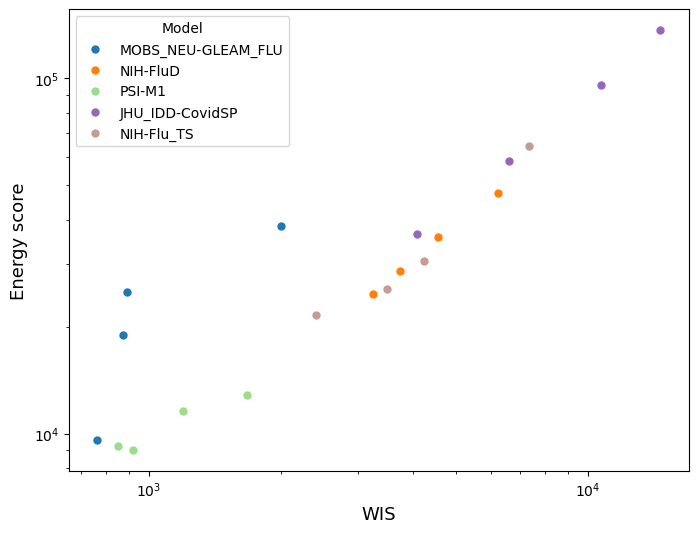

In [181]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17
es = pd.read_pickle('./energyscore_models_flurd3_US_hosp.pkl')

wisdf = pd.read_pickle('./flurd3_wis__hosp_models.pkl') 
#wisdf = wisdf.rename(columns={'Location':'location_name'})

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in [ "MOBS_NEU-GLEAM_FLU",'NIH-FluD', 
          'PSI-M1', 'JHU_IDD-CovidSP', 'NIH-Flu_TS' ]:
    wis = wisdf[wisdf.Model == model]

    if model == "MOBS_NEU-GLEAM_FLU":
        esmod = es[es.Model == 'MOBS']
    else:
        esmod = es[es.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.',color = colors[i],markersize=10, label = model)
    
    i+=1
    
plt.xlabel('WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)


plt.legend(title='Model')

#plt.savefig('energyscore_wis_flu')
plt.show()